In [0]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory
import re
import os
import nltk
import gensim
from tqdm import tqdm, tqdm_notebook
# Any results you write to the current directory are saved as output.

In [0]:
from gensim.test.utils import get_tmpfile
from gensim.models import KeyedVectors
#load w2v
fname = get_tmpfile('mimic3_rad_sim.kv')
embeddings = KeyedVectors.load(fname, mmap='r')
#embeddings.init_sims(replace=True)

In [0]:
#Load ct reports 
ct_dataset = pd.read_csv('ct_dataset.csv',index_col=0)
#ct_dataset.head()

In [0]:
#Data cleaning
#cln_text = [re.sub("[^A-Za-z0-9']+", ' ', str(row)).lower() for row in tqdm_notebook(ct_dataset.iloc[:,0])]
cln_text = [row.lower() for row in tqdm_notebook(ct_dataset.iloc[:,0])]

In [0]:
ct_dataset['text'] = cln_text
#ct_dataset.head()

In [0]:
# Data check
sample = np.random.randint(95573,size=1000)
ct_sp = ct_dataset.iloc[sample,:] 
#ct_sp.head()
ct_sp.groupby('site').count()

,text,exam
site,,
Abd&pelvis,227,227
chest,239,239
ext,9,9
head&neck,449,449
spine,76,76


In [0]:
# Embedding ct reports
docs_vectors = [] # creating empty final dataframe
for doc in tqdm_notebook(ct_sp['text']): # looping through each document and cleaning it
    #print(doc)
    temp = []  # creating a temporary dataframe(store value for 1st doc & for 2nd doc remove the details of 1st & proced through 2nd and so on..)
    for word in doc.split(' '): # looping through each word of a single document and spliting through space
        #print(word)
        try:
            word_vec = embeddings[word] # if word is present in embeddings
            #print(word_vec)
            temp.append(word_vec) # if word is present then append it to temporary dataframe
        except:pass
    temp = np.array(temp)
    #print(temp)
    #print(temp.mean(axis=0).shape)
    #print()
    #print(temp.mean(axis=1).shape)
     # take the average of each column(w0, w1, w2,........w300)
    docs_vectors.append(temp.mean(axis=0)) # append each document value to the final dataframe
docs_vectors = np.array(docs_vectors)
docs_vectors.shape
#print(docs_vectors[0])

(1000, 300)

In [0]:
from sklearn.model_selection import train_test_split
train_x, test_x, train_y, test_y = train_test_split(docs_vectors,
                                                   ct_sp['site'],
                                                   test_size = 0.2,
                                                   random_state = 1)
train_x.shape, train_y.shape, test_x.shape, test_y.shape

((800, 300), (800,), (200, 300), (200,))

In [0]:
# PCA + SVC

from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline

pca = PCA(n_components=100, whiten=True, random_state=42)
svc = SVC(kernel='rbf', class_weight='balanced')
model = make_pipeline(pca, svc)

In [0]:
# tuning with gridsearch
from sklearn.model_selection import GridSearchCV
param_grid = {'svc__C': [1, 5, 10, 50],
              'svc__gamma': [0.0001, 0.0005, 0.001, 0.005]}
grid = GridSearchCV(model, param_grid)

%time grid.fit(train_x, train_y)
print(grid.best_params_)


/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


CPU times: user 13.4 s, sys: 1.65 s, total: 15.1 s
Wall time: 5.31 s
{'svc__C': 50, 'svc__gamma': 0.0001}


/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


In [0]:
model = grid.best_estimator_
predictions = model.predict(test_x)

Accuracy:  0.95
              precision    recall  f1-score   support

  Abd&pelvis       0.92      0.88      0.90        40
       chest       0.88      0.94      0.91        48
         ext       1.00      0.50      0.67         2
   head&neck       0.99      0.99      0.99        95
       spine       1.00      1.00      1.00        15

    accuracy                           0.95       200
   macro avg       0.96      0.86      0.89       200
weighted avg       0.95      0.95      0.95       200



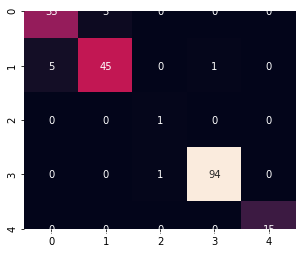

In [0]:
# Validation
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import seaborn as sns

accuracy = accuracy_score(test_y, predictions)
print('Accuracy: ',accuracy)
report = classification_report(test_y, predictions)
print(report)
mat = confusion_matrix(test_y, predictions)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
            #xticklabels=ct_sp.index.value,
            #yticklabels=faces.target_names
           )


In [0]:
# Random forest classifier
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(n_estimators=1500,class_weight='balanced')


In [0]:
rf.fit(train_x, train_y)
predictions = rf.predict(test_x)

Accuracy:  0.92
              precision    recall  f1-score   support

  Abd&pelvis       0.89      0.85      0.87        40
       chest       0.83      0.90      0.86        48
         ext       0.00      0.00      0.00         2
   head&neck       0.97      0.97      0.97        95
       spine       1.00      1.00      1.00        15

    accuracy                           0.92       200
   macro avg       0.74      0.74      0.74       200
weighted avg       0.91      0.92      0.92       200



/usr/local/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


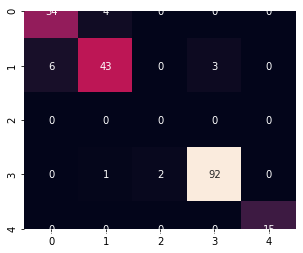

In [0]:
accuracy = accuracy_score(test_y, predictions)
print('Accuracy: ',accuracy)
report = classification_report(test_y, predictions)
print(report)
mat = confusion_matrix(test_y, predictions)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
            #xticklabels=ct_sp.index.value,
            #yticklabels=faces.target_names
           )


In [0]:
# word level tf-idf
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import TruncatedSVD
tfidf_vect = TfidfVectorizer(analyzer='word', token_pattern=r'\w{1,}')
tfidf_vect.fit(ct_sp['text'])
train_x, test_x, train_y, test_y = train_test_split(ct_sp['text'],
                                                   ct_sp['site'],
                                                   test_size = 0.2,
                                                   random_state = 1)
train_x.shape, train_y.shape, test_x.shape, test_y.shape
xtrain_tfidf =  tfidf_vect.transform(train_x)
xtest_tfidf =  tfidf_vect.transform(test_x)

In [0]:
tsvd = TruncatedSVD(n_components=100, n_iter=10, random_state=42)
svc = SVC(kernel='rbf', class_weight='balanced')
model = make_pipeline(tsvd, svc)

In [0]:
from sklearn.model_selection import GridSearchCV
param_grid = {'svc__C': [1, 5, 10, 50],
              'svc__gamma': [0.0001, 0.0005, 0.001, 0.005]}
grid = GridSearchCV(model, param_grid)

%time grid.fit(xtrain_tfidf, train_y)
print(grid.best_params_)


/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


CPU times: user 53.2 s, sys: 7.37 s, total: 1min
Wall time: 29.2 s
{'svc__C': 50, 'svc__gamma': 0.005}


In [0]:
model = grid.best_estimator_
predictions = model.predict(xtest_tfidf)

Accuracy:  0.925
              precision    recall  f1-score   support

  Abd&pelvis       0.84      0.93      0.88        40
       chest       0.89      0.85      0.87        48
         ext       0.00      0.00      0.00         2
   head&neck       0.98      0.97      0.97        95
       spine       1.00      1.00      1.00        15

    accuracy                           0.93       200
   macro avg       0.74      0.75      0.75       200
weighted avg       0.92      0.93      0.92       200



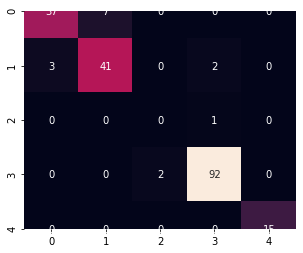

In [0]:
accuracy = accuracy_score(test_y, predictions)
print('Accuracy: ',accuracy)
report = classification_report(test_y, predictions)
print(report)
mat = confusion_matrix(test_y, predictions)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
            #xticklabels=ct_sp.index.value,
            #yticklabels=faces.target_names
           )
